# Introduction to Neural Networks 

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.python.keras as K 
from tensorflow.python.keras.layers import Dense
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split


## Data Preparation

In [100]:
PATH = "../datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


dropping the `customerID` column since it is not of importance.

In [101]:
df = df.drop(columns=['customerID'], axis=1)

`TotalCharges` column is found to have empty strings. this gets in the way of converting it into a numerical dtype. so, we have to replace the empty string and then convert the data type.

In [102]:
df.TotalCharges = df.TotalCharges.replace(['', ' '], '0')
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

splitting the dataset into *label* (X) and *target* (y) is useful since we are creating a supervised neural network model. 

to also help with the encoding process, we will keep a list of column names which are categorical and which are not. 

In [103]:
label = df.drop(columns=['Churn'], axis=1)
target = df['Churn']

categoric_cols = label.select_dtypes(include=['object']).columns.tolist()
numeric_cols = label.select_dtypes(include=['int64', 'float64']).columns.tolist()

split the dataset into "training", "testing", and "validation", with the ratio of 60:20:20

In [104]:
X_train, X_test, y_train, y_test = train_test_split(label,
                                                    target, 
                                                    test_size=.4, 
                                                    random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, 
                                                y_test, 
                                                test_size=.5, 
                                                random_state=42)

## Data Preprocessing(?)    

In [105]:
encoder = OrdinalEncoder()
scaler = StandardScaler()

here's the idea, **splitting machine learning datasets before encoding categorical data is considered best practice** for a number of reasons. a few of them being:  

1. preventing data leakage
2. maintaining distribution
3. handling unknown categories
4. better model generalization

> you can read more about this [here](ihttps://datascience.stackexchange.com/questions/107714/encoding-before-vs-after-train-test-split)

and the way to encode our dataset after splitting is by **using `fit_transform()` on the training set and `transform()` for the validation and test sets** ([this](https://sebastianraschka.com/faq/docs/scale-training-test.html) article explains it nicely)

also, know that encoders (such as `OrdinalEncoder` which we are using here) is unable to encode numerical values when encountering them via the `transform()` method (reasons i do not fully understand yet). hence, the bits of code below is a bit long.

In [106]:
X_train_categoric_encoded = encoder.fit_transform(X_train[categoric_cols])
X_train_numeric = X_train[numeric_cols]

X_train_encoded = pd.DataFrame(
    X_train_categoric_encoded, 
    columns=encoder.get_feature_names_out(categoric_cols)
)
X_train_encoded = pd.concat([X_train_encoded, 
                             X_train_numeric.reset_index(drop=True)], 
                             axis=1)

what the snippet above does is essentially encoding only the categorical data by differentiating between categorical and numerical data. after the encoding process is done, they are then concatenated into a single `DataFrame` again. 

notice that the first line of the snippet above and below is different for reasons we discussed before (use `fit_transform()` **only** on training data).

In [107]:
X_test_categoric_encoded = encoder.transform(X_test[categoric_cols])
X_test_numeric = X_test[numeric_cols]

X_test_encoded = pd.DataFrame(
    X_test_categoric_encoded, 
    columns=encoder.get_feature_names_out(categoric_cols)
)
X_test_encoded = pd.concat([X_test_encoded, 
                             X_test_numeric.reset_index(drop=True)], 
                             axis=1)

In [108]:
X_val_categoric_encoded = encoder.transform(X_val[categoric_cols])
X_val_numeric = X_val[numeric_cols]

X_val_encoded = pd.DataFrame(
    X_val_categoric_encoded, 
    columns=encoder.get_feature_names_out(categoric_cols)
)
X_val_encoded = pd.concat([X_val_encoded, 
                             X_val_numeric.reset_index(drop=True)], 
                             axis=1)

before encoding the target data, it must first be reshaped. this is because a Pandas series is a 1D (`(n, )`) list(?) as opposed to a column vector (`(n, 1)`), or what is better known as a 2D array.

In [109]:
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1,1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1,1))
y_val_encoded = encoder.transform(y_val.values.reshape(-1,1))

## Building a Neural Network Model

In [110]:
model = K.Sequential([
    Dense(1, activation='sigmoid', input_shape=(X_train_encoded.shape[1], ))
])

In [111]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [112]:
history = model.fit(X_train_encoded, 
                    y_train_encoded, 
                    epochs=50,
                    validation_data=(X_val_encoded, y_val_encoded))

Epoch 1/50
133/133 [==============================] - 1s 2ms/step - loss: 145.6821 - accuracy: 0.7328 - val_loss: 103.7710 - val_accuracy: 0.7346
Epoch 2/50
133/133 [==============================] - 0s 2ms/step - loss: 93.7663 - accuracy: 0.7427 - val_loss: 58.3156 - val_accuracy: 0.7665
Epoch 3/50
133/133 [==============================] - 0s 2ms/step - loss: 42.6982 - accuracy: 0.7420 - val_loss: 15.1668 - val_accuracy: 0.7402
Epoch 4/50
133/133 [==============================] - 0s 2ms/step - loss: 6.8726 - accuracy: 0.6367 - val_loss: 4.0856 - val_accuracy: 0.6104
Epoch 5/50
133/133 [==============================] - 0s 2ms/step - loss: 3.5653 - accuracy: 0.6031 - val_loss: 2.6117 - val_accuracy: 0.6835
Epoch 6/50
133/133 [==============================] - 0s 2ms/step - loss: 2.0386 - accuracy: 0.6424 - val_loss: 1.1881 - val_accuracy: 0.7019
Epoch 7/50
133/133 [==============================] - 0s 2ms/step - loss: 0.8864 - accuracy: 0.7124 - val_loss: 0.5285 - val_accuracy: 0.759

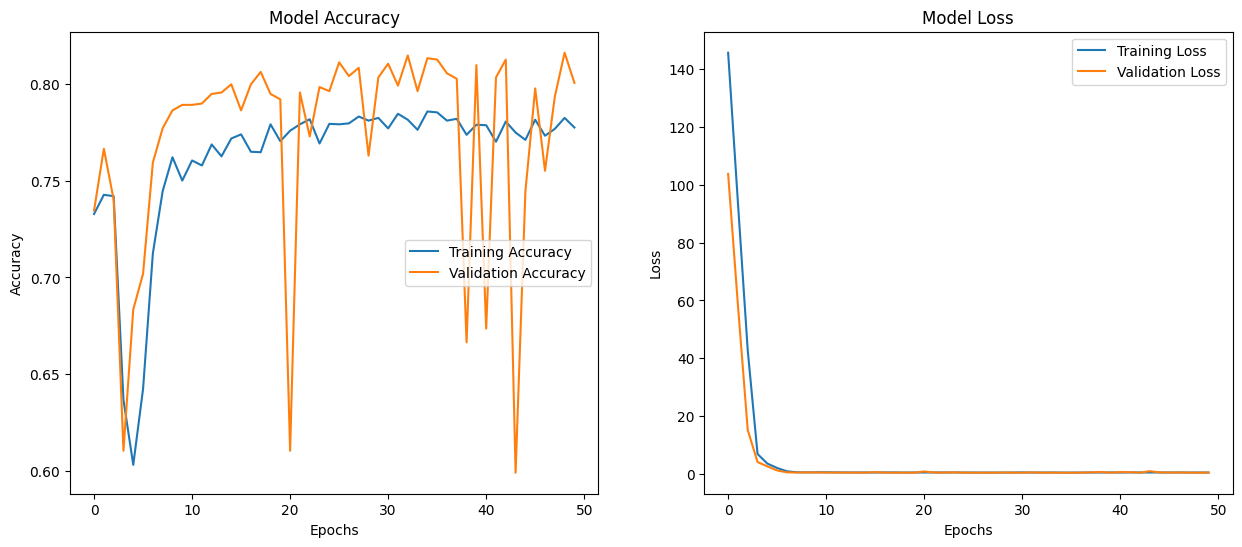

In [113]:
fig, (ax1, ax2) = plt.subplots(1,2,
                               figsize=(15,6))

ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend()

In [114]:
predictions = model.predict(X_test_encoded[:20])
prediction_label = [1 if p >= .5 else 0 for p in predictions]

actual = y_test_encoded[:20]
actual_label = [1 if p >= .5 else 0 for p in predictions]

print("{title:<20} {pred}".format(title="Prediction Labels:", pred=prediction_label))
print("{title:<20} {actual}".format(title="Actual Labels:", actual=actual_label))

loss, accuracy = model.evaluate(X_test_encoded, y_test_encoded)
print("Accuracy: {0}; Loss: {1}".format(accuracy, loss))

Prediction Labels:   [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Actual Labels:       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
45/45 [==============================] - 0s 1ms/step - loss: 0.4806 - accuracy: 0.8020
Accuracy: 0.8019872307777405; Loss: 0.48058271408081055
